# Assignment 3: Convolutions and local structure

## Working with notebooks

The assignments for this week are given in this notebook. An additional notebook with examples is provided as well. Only this notebook will be graded.

**Always use `Kernel > Restart & Run All` and check the results before handing in your assignment**.

Some general tips:

- Avoid using packages that are not already imported in the assignment template, and are not default Python packages.
- Avoid using "notebook magic" like `%matplotlib inline`; such commands do not work when the notebook is converted to a Python script.

## Working with Codegrade

The assignments for this course are (partly) automatically graded by a system called *Codegrade*. Our tests will run on your code automatically, and give grades based purely on the correctness of the output.

Some of the Codegrade tests will be run immediately, and you can view the output/results before the deadline (it may take a couple of minutes to show up). Use this to check that your code is working correctly, and that you are in the right direction for the assignments.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import wget
from scipy.ndimage.filters import convolve
from scipy.ndimage import uniform_filter
import mpl_toolkits.mplot3d.art3d as art3d

np.set_printoptions(precision=3,
                    suppress=True) # change this in case you need more precision

def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)
    
def plot_stems3d(ax, x, y, z):
    for xi, yi, zi in zip(x.flatten(), y.flatten(), z.flatten()):  
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), marker='o', markevery=(1, 1))
        ax.add_line(line)
    ax.set_xlim3d(X.min(), X.max())
    ax.set_ylim3d(Y.min(), Y.max())
    ax.set_zlim3d(np.minimum(G.min(), 0), np.maximum(G.max(),0))

    
try:
    Fcam = plt.imread('cameraman.png')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/cameraman.png")
    Fcam = plt.imread('cameraman.png')

/tmp/ipykernel_4983/2434823953.py:4: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


## Exercise 1: Separable Convolutions

In the code cell below you have to time the three versions of the uniform convolution for values of N in ``sizes = np.array([3,5,7,9,11,15,19,25,31])``. You can use the ``timeit`` Python package for timing purposes (**set ``number=10`` and ``globals=globals()``**). You should present the timing results in *one* plot, clearly labelling the three versions and the axes. Then, answer the questions below.

Note: this particular exercise is not autograded.

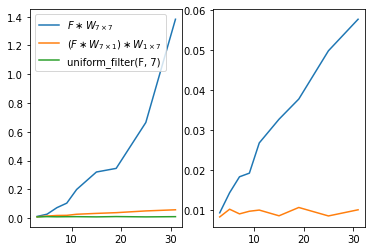

In [25]:
try:
    Fcam = plt.imread('cameraman.png')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/cameraman.png")
    Fcam = plt.imread('cameraman.png')

from scipy.ndimage import uniform_filter
import timeit
sizes = np.array([3, 5, 7, 9, 11, 15, 19, 25, 31])

def profile_function(sizes, function):
    times = np.zeros_like(sizes, dtype=np.float64)
    for i, size in enumerate(sizes):
        times[i] = timeit.timeit(lambda: function(size), number=10, globals=globals())
    return times

time_7x7 = profile_function(sizes, lambda size: convolve(Fcam, np.ones((size, size))))
time_sep_7 = profile_function(sizes, lambda size: convolve(convolve(Fcam, np.ones((size, 1))), np.ones((1, size))))
time_scipy = profile_function(sizes, lambda size: uniform_filter(Fcam, size))
plt.subplot(121)
plt.plot(sizes, time_7x7, label=r'$F\ast W_{7\times7}$')
plt.plot(sizes, time_sep_7, label=r'$(F\ast W_{7\times1})\ast W_{1\times7}$')
plt.plot(sizes, time_scipy, label="uniform_filter(F, 7)")
plt.legend()
plt.subplot(122)
plt.plot(sizes, time_sep_7)
plt.plot(sizes, time_scipy)
plt.show();

**Questions.**

1. Comment on the timing diagrams (are they showing the expected behaviour?)

2. The timing of the ``uniform_filter`` should be surprising (hint: plot the timing diagrams for the separable convolution and the ``uniform_filter`` in one plot to see the difference more clearly) . Comment on this as well. What do you think is done to reach this performance?

Yes, since for the larger kernels, the naive implementation with the complete kernel is much slower than the faster implementation with the splitted kernels.
SciPy is optimized for convolutions, it is faster than an implementation with Python overhead.
And it uses a rolling sum average for computing the average along the axis, this is faster than calculating the average for each point on the axis, which results in a much faster time than the seperated convolutions.

## Exercise 2: Impulse responses

The following filters from ``scipy.ndimage`` are all linear translation invariant filters:
 - sobel
 - laplace
 - prewitt
 - gaussian_laplace

Some of these functions have parameters that result in different kernels being used.

For each of these filter determine the impulse response. Return the impulse response function but only the smallest square part of the image centered at the middle showing non-zero responses. I.e. for the impulse response of the uniform filter of size 7x7 you should return a 7x7 array with all values 0.02 (remember we have set the number of digits to two...).

In [26]:
from scipy.ndimage import sobel, laplace, prewitt, gaussian_laplace

def sobel_filter():
    array = np.zeros((3,3))
    array[1,1] = 1
    return sobel(array)

def laplace_filter():
    array = np.zeros((3, 3))
    array[1,1] = 1
    return laplace(array)

def prewitt_filter():
    array = np.zeros((3,3))
    array[1,1] = 1
    return prewitt(array)

def gaussian_laplace_filter():
    array = np.zeros((9,9))
    array[4,4] = 1
    return gaussian_laplace(array, 1)

To understand what these filters do, also run the filters on the cameraman image (or any other image of your liking). What do you expect to do, or have read the filter is supposed to do?

## Exercise 3: Impulse responses

Given only the right and left first order derivative filters (from a previous section) with convolution kernels
   ``{1 -1 0}`` and ``{0 1 -1}`` both in horizontal direction as well as in vertical direction, can you make the laplace filter using only these four first order derivatives? Hint: first write the impulse response function as the addition of a horizontal function and a vertical function. (Answer in code in the cell below this one: use the definitions given in the cell below, as well as the function `convolve`, to define the Laplace filter.)

In [27]:
def laplace_derivatives(I):
    """
    Using only the convolve function and these four filters, compute the laplace filter of I.
    """
    Dleft = np.array([[ 0,  1, -1]])
    Dright = np.array([[ 1, -1,  0]])
    Dup = Dleft.T
    Ddown = Dright.T

    kernel_horizontal = np.vstack(([0, 0, 0], Dright - Dleft, [0, 0, 0]))
    kernel_vertical = kernel_horizontal.T

    complete = kernel_horizontal + kernel_vertical

    return convolve(I, complete)

## Exercise 4: Anaytical derivatives

Consider the function $f$ in two variables:
\begin{align}
f(x,y) = A\sin(Vx) + B\cos(Wy)
\end{align}

We set the following values for the constants $A$, $B$, $V$ and $W$:
\begin{align}
A &= 1\\
B &= 2\\
V &= \frac{6\pi}{100}\\
W &= \frac{4\pi}{100}
\end{align}

In the cell below write the code to generate the discrete images (sampled functions) ``F``, ``Fx`` and ``Fy``. Here ``F`` is the sampled version (on the grid defined by ``X`` and ``Y``) of $f$, ``Fx`` and ``Fy`` are the sampled versions of $f_x$ and $f_y$ respectively. Also plot the three images in a row (you can use the ``imshow_row`` for this). (2p)

In [28]:
def F_partial_derivatives(X, Y):
    A = 1
    B = 2
    V = 6 * np.pi / 100
    W = 4 * np.pi / 100

    F = A * np.sin(V * X) + B * np.cos(W * Y)
    Fx = A * V * np.cos(V * X)
    Fy = -B * W * np.sin(W * Y)

    return F, Fx, Fy


0.15249611076945777
-0.2390265731793245


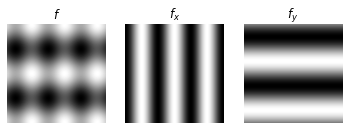

In [29]:
x = np.arange(-50,51)
y = np.arange(-50,51)
X, Y = np.meshgrid(x, y)

F, Fx, Fy = F_partial_derivatives(X, Y)
imshow_row([(F, r"$f$"),
            (Fx, r"$f_x$"),
            (Fy, r"$f_y$")])
plt.gray()

print(Fx[10, 20])
print(Fy[10, 20])

Test your implemantation using the following code.

In [30]:
assert F.shape == Fx.shape == Fy.shape == (101, 101)

assert np.isclose(F[10, 20], 1.2058192410423678)
assert np.isclose(Fx[10, 20], 0.15249611076945777)
assert np.isclose(Fy[10, 20], -0.2390265731793245)

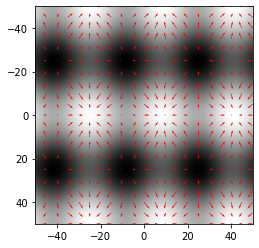

In [31]:
xx = x[::5]
yy = y[::5]
XX = X[::5, ::5]
YY = Y[::5, ::5]
FFx = Fx[::5, ::5]
FFy = Fy[::5, ::5]
plt.imshow(F, extent=(-50, 50, 50, -50), origin='upper')
plt.quiver( xx, yy, FFx, FFy, color='red', angles='xy' );

Observe that the gradient vectors plotted starting in the points of less dense grid (defined by ``XX`` and ``YY``) and if all is well should point in the direction of the maximal increase in the function value (i.e. towards the centers of the bright white spots).

## Exercise 5: Finite Difference Derivatives

Consider the function $f$ in two variables:

\begin{align}
f(x,y) = 3(1-x)^2 \exp\left(-x^2 - (y-1)^2\right)
 - 10\left(\frac{x}{5} - x^3 - y^5\right) \exp\left(-x^2 - y^2\right) 
 - \frac{1}{3} \exp\left(-(x+1)^2 - y^2\right)
 \end{align}
 
In the cell below you should approximate the partial derivatives (call the variables ``Fxml`` and ``Fyml``) using finite difference convolutions

In [32]:
import scipy.ndimage # Contains the convolve function.

def finite_difference_derivatives(Xml, Yml):
    """
    Given a grid Xml, Yml (in the output format of np.meshgrid), compute (using finite difference convolutions):
    
    Fml (given): the value of the function f on the grid.
    Fxml: the deriviative in the x direction.
    Fyml: the derivative in the y direction.
    
    Return Fml, Fxml, Fyml.
    """
    Fml = 3 * (1-Xml)**2 * np.exp(-(Xml**2) - (Yml+1)**2) \
        - 10 * (Xml/5 - Xml**3 - Yml**5) * np.exp(-Xml**2 - Yml**2) \
        - 1/3 * np.exp(-(Xml+1)**2 - Yml**2)
    
    kernel = np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]])
    Fxml = convolve(Fml, kernel)
    Fyml = convolve(Fml, kernel.T)

    return Fml, Fxml, Fyml


Test your implemantation using the following code.

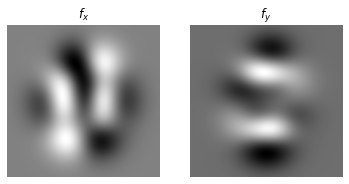

In [33]:
xml = np.linspace(-3, 3, 150)
yml = np.linspace(-3, 3, 150)
Xml, Yml = np.meshgrid(xml, yml)
Fml, Fxml, Fyml = finite_difference_derivatives(Xml, Yml)

imshow_row([(Fxml, r"$f_x$"), (Fyml, r"$f_y$")])

assert Fxml.shape == Fyml.shape == (150, 150)
assert np.isclose(Fxml[50, 60], -0.04245716117236498)
assert np.isclose(Fyml[50, 60], 0.29461883737214256)

The code below then should plot the gradient vectors in a sparse grid overlayed on top of the image ``Fml``.

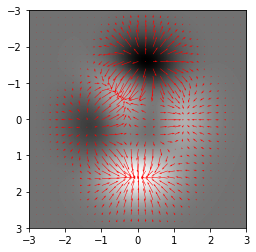

In [34]:
xxml = xml[::5]
yyml = yml[::5]
XXml = Xml[::5, ::5]
YYml = Yml[::5, ::5]
FFxml = Fxml[::5, ::5]
FFyml = Fyml[::5, ::5]
plt.imshow(Fml, extent=(-3, 3, 3, -3), origin='upper')
plt.quiver(xxml, yyml, FFxml, FFyml, color='red', angles='xy');

## Exercise 6: Gaussian 2D function

The 2D Gaussian function $G^s(x,y)$ is defined as:
\begin{align}
G^s(x,y) = \frac{1}{s\sqrt{2\pi}} e^{-\frac{x^2+y^2}{2 s^2}}
\end{align}

The function ``Gauss2d(scale, factor)`` should a return a tuple ``(X, Y, G)`` where ``X, Y`` are the 2D grid arrays generated with the ``np.meshgrid`` function and ``G`` is the sampled Gaussian function.

The Gauss kernel should be **normalized** in such a way that at each point in the image it calculates a weighted average of its neighbor points. (2p)

In [43]:
def Gauss2d(scale, factor):
    # If we take N = ceil(scale*factor), then a 2N+1 x 2N + 1 filter is a good size for the grid.
    N = np.ceil(scale * factor).astype(int)

    X = np.arange(-N, N + 1)
    Y = np.arange(-N, N + 1)
    X, Y = np.meshgrid(X, Y)
    G = (
        (1 / (scale * np.sqrt(2 * np.pi)))
        * np.exp(-(X**2 + Y**2) / (2 * scale**2))
        / scale
    )

    G = G / np.sum(G)

    return X, Y, G

Test your implemantation using the following code.

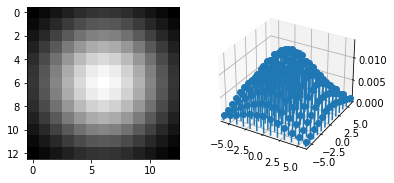

In [44]:
X, Y, G = Gauss2d(3.7, 1.4)
fig = plt.figure(99)
ax1 = fig.add_subplot(121)
ax1.imshow(G);
ax2 = fig.add_subplot(122, projection='3d')
plot_stems3d(ax2, X, Y, G)

In [45]:
X, Y, G = Gauss2d(3.7, 1.4)
assert X.shape == Y.shape == G.shape == (13, 13)
assert np.isclose(np.sum(G), 1)
assert X[1,4] == -2
assert Y[1,4] == -5
assert np.isclose(G[1,4], 0.004742521299253816)

## Exercise 7: 1D Gaussian function


Using the calculated partial derivatives, now write the code for the ``Gauss1D`` function (and your derivatives will be tested then). (3p)

In [ ]:
def Gauss1d(scale, order=0, factor=3):
    """If order=0, this function should give a normalized sample of the 1d Gaussian function,
    similar to the Gauss2d function above. If order=1 or order=2, this function should give an
    approximation for the first respectively second derivative by multiplying this sample by the
    appropriate analytically determined polynomial (see guide notebook)."""
    N = np.ceil(scale * factor).astype(int)

    X = np.arange(- N, N + 1)
    ### YOUR CODE HERE
    G = (1 / (scale * np.sqrt(2 * np.pi))) * np.exp(-(X**2) / (2 * scale**2))
    G = G / np.sum(G)
    if order == 0:
        G = G /  np.sum(G)
        return X, G
    if order == 1:
        G = -X * G / scale ** 2
        return X, G
    if order == 2:
        G = (X**2 - scale**2) / scale**4 * G
        return X, G

Test your implemantation using the following code.

In [41]:
x0, G0 = Gauss1d(1.5, 0, 5)
x1, G1 = Gauss1d(1.5, 1, 5)
x2, G2 = Gauss1d(1.5, 2, 5)
assert x0.shape == G0.shape == (17,)
assert (x0 == x1).all() and (x1 == x2).all()
assert np.isclose(np.sum(G0), 1)
assert np.isclose(G0[4], 0.0075973240783234215)
assert np.isclose(G1[4], 0.013506353917019416)
assert np.isclose(G2[4], 0.020634707373224107)

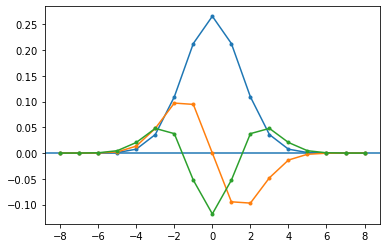

In [42]:
s = 1.5
factor = 5
x, G3 = Gauss1d(s, order=0, factor=factor)
plt.plot(x, G3, '.-')
x, G3x = Gauss1d(s, order=1, factor=factor)
x, G3xx = Gauss1d(s, order=2, factor=factor)
plt.axhline() # the x-axis
plt.plot(x, G3x, '.-');
plt.plot(x, G3xx, '.-');

## Exercise 8: Gaussian (Derivative) Convolution

Use the function ``Gauss1d`` and ``convolve1d`` to implement the ``gD`` function:

In [35]:
from scipy.ndimage import convolve1d


def gD(f, scales, orders, factor=3, mode="nearest", cval=0):
    """
    f: the function to convolve
    scales: the scales in the x and y direction, respectively
    orders: the orders of the derivatives (0 <= order <= 2)
    factor: the factor with which you compute the scale to get the size of the domain.
    mode, cval: the border mode to use in the convolution, and the constant value in case the mode is `constant`.

    returns: the convolution of f with the appropriate Gaussian derivative.
    """

    ### YOUR CODE HERE
    _, gauss_kernel_horizontal = Gauss1d(scales[0], orders[0], factor)
    _, gauss_kernel_vertical = Gauss1d(scales[1], orders[1], factor)

    return convolve1d(
        convolve1d(f, gauss_kernel_horizontal, axis=0, mode=mode, cval=cval),
        gauss_kernel_vertical,
        axis=1,
        mode=mode,
        cval=cval,
    )

Test your implemantation using the following code.

In [36]:
F = np.array([[65, 13, 15, 18, 69, 39, 38, 19, 61,  5],
       [55, 35, 12, 96, 95, 98, 80,  2, 86, 22],
       [41, 39, 91, 33, 68, 52, 18, 46, 82, 16],
       [96, 48, 57, 28, 79, 10, 84, 18, 46, 92],
       [41, 70, 32, 59, 15, 48, 58, 96, 88, 99],
       [78, 48, 26, 68, 56, 97, 79, 19, 55, 59],
       [80,  6, 54, 93, 10, 28, 10, 69, 25, 27],
       [44, 33, 25, 73, 92, 41, 15, 23, 78,  9],
       [ 3, 48,  0, 69,  6, 82, 33, 59, 22, 28],
       [66, 94, 18, 17, 13, 73, 16, 18, 25, 64]]).astype(np.float64)
F01 = gD(F, (3.5, 3.5), (0, 1), 3)
F21 = gD(F, (2.5, 2.5), (2, 1), 3)
assert F01.shape == F21.shape == (10, 10)
assert np.isclose(F01[4, 5], -0.6600031308571785)
assert np.isclose(F21[6, 3], -0.1254832128531149)

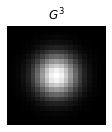

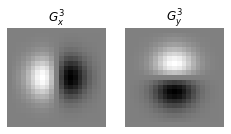

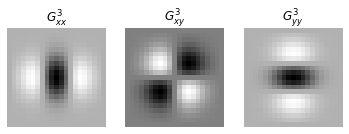

In [37]:
# Show the derivatives by convolving with an impulse.
I = np.zeros((21,21))
I[10, 10] = 1
G3 = gD(I, (3,3), (0,0), 3)
imshow_row([ (G3, r"$G^3$"), None, None])

plt.figure()
Gx3 = gD(I, (3,3), (0,1), 3)
Gy3 = gD(I, (3,3), (1,0), 3)
imshow_row([ (Gx3, r"$G^3_x$"), (Gy3, r"$G^3_y$"), None])

plt.figure()
Gxx3 = gD(I, (3,3), (0,2), 3)
Gxy3 = gD(I, (3,3), (1,1), 3)
Gyy3 = gD(I, (3,3), (2,0), 3)
imshow_row([ (Gxx3, r"$G^3_{xx}$"), 
             (Gxy3, r"$G^3_{xy}$"),
             (Gyy3, r"$G^3_{yy}$")])


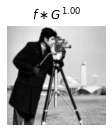

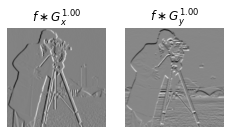

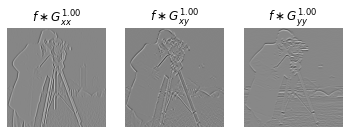

In [38]:
s = 1
fs = gD(Fcam, (s,s), (0,0), 3)
imshow_row([ (fs, r"$f\ast G^{%5.2f}$" % s), None, None])

plt.figure()
fxs = gD(Fcam, (s,s), (0,1), 3)
fys = gD(Fcam, (s,s), (1,0), 3)
imshow_row([(fxs, r"$f\ast G^{%5.2f}_x$" % s), 
            (fys, r"$f\ast G^{%5.2f}_y$" % s), 
            None])

plt.figure()
fxxs = gD(Fcam, (s,s), (0,2), 3)
fxys = gD(Fcam, (s,s), (1,1), 3)
fyys = gD(Fcam, (s,s), (2,0), 3)
imshow_row([ (fxxs, r"$f\ast G^{%5.2f}_{xx}$" % s), 
             (fxys, r"$f\ast G^{%5.2f}_{xy}$" % s),
             (fyys, r"$f\ast G^{%5.2f}_{yy}$" % s)])


## Exercise 9: Canny Edge Detector

Implement the Canny edge detector using the ``gD`` function that you have implemented in previous sections.

The result of the function ``E = canny(F, s)`` should be an image ``E`` where the value in a pixel equals the gradient norm (in that pixel) in case it is an edge pixel and zero otherwise.

To find the zero crossings in an image you can write a simple function that looks in each 3x3 neighborhood of a pixel whether there are both negative and positive values on opposite sides of the central pixel. This is not a perfect solution but it does the job quite well. The ``generic_filter`` function can be of help here.

Test your canny function on the camereman image. Show the results for several scales used in the derivatives calculations, and comment on your results and the differences..

In [58]:
from scipy.ndimage import generic_filter
from matplotlib.pylab import hypot


def zero_crossing(nbh):
    """
    Takes a 3x3 neighborhood of a point given as a 1D array with 9 elements, and
    determines whether that point is a zero crossing. (Input as a 1D array, since
    this is the format used by generic_filter.)
    """
    f1, f2, f3, f4, f5, f6, f7, f8, f9 = nbh
    if f1 * f9 < 0:
        return 1
    if f2 * f8 < 0:
        return 1
    if f3 * f7 < 0:
        return 1
    if f4 * f6 < 0:
        return 1
    return 0


def canny(F, scale):
    x = gD(F, (scale, scale), (0, 1))
    y = gD(F, (scale, scale), (1, 0))
    cannied = np.sqrt(x**2 + y**2)
    xx = gD(F, (scale, scale), (0, 2))
    yy = gD(F, (scale, scale), (2, 0))
    xy = gD(F, (scale, scale), (1, 1))
    zero_cross = np.multiply(x**2, xx) + 2 * np.multiply(np.multiply(x, y), xy) + np.multiply(y**2, yy)
    return cannied * generic_filter(zero_cross, zero_crossing, (3, 3))

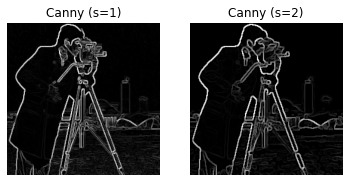

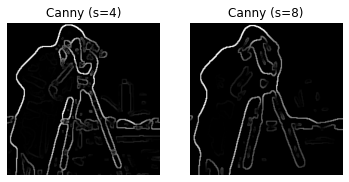

In [59]:
F = plt.imread('cameraman.png')
zc1 = canny(F, 1)
zc2 = canny(F, 2)
zc4 = canny(F, 4)
zc8 = canny(F, 8)

imshow_row([(zc1, "Canny (s=1)"),
            (zc2, "Canny (s=2)")])
plt.figure()
imshow_row([(zc4, "Canny (s=4)"),
            (zc8, "Canny (s=8)")])